# Линейная алгебра: сходство текстов и аппроксимация функций

### Вы научитесь:
  * читать тексты из файла с помощью Python и разбивать их на слова
  * переводить тексты в векторные пространства, вычислять расстояния в этих пространствах
  * решать системы линейных уравнений
  * приближать любые функции с помощью многочленов
  
## Введение

В этом задании вы познакомитесь с некоторыми базовыми методами из линейной алгебры, реализованными в пакете SciPy — в частности, с методами подсчета косинусного расстояния и решения систем линейных уравнений. Так, на решении систем линейных уравнений основана настройка линейных моделей — очень большого и важного класса алгоритмов машинного обучения. Косинусное расстояние же часто используется в анализе текстов для измерения сходства между ними.

## Материалы

Справка по функциям пакета scipy.linalg: http://docs.scipy.org/doc/scipy/reference/linalg.html

Справка по работе с файлами в Python: https://docs.python.org/2/tutorial/inputoutput.html#reading-and-writing-files

Справка по регулярным выражениям в Python (если вы захотите узнать про них чуть больше): https://docs.python.org/2/library/re.html

## Задача 1: сравнение предложений

Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:

  * кошки (животные)
  * UNIX-утилита cat для вывода содержимого файлов
  * версии операционной системы OS X, названные в честь семейства кошачьих
Ваша задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу мы будем использовать косинусное расстояние.

#### Выполните следующие шаги:

1. Скачайте файл с предложениями (sentences.txt).
2. Каждая строка в файле соответствует одному предложению. Считайте их, приведите каждую к нижнему регистру с помощью строковой функции lower().
3. Произведите токенизацию, то есть разбиение текстов на слова. Для этого можно воспользоваться регулярным выражением, которое считает разделителем любой символ, не являющийся буквой: re.split('[^a-z]', t). Не забудьте удалить пустые слова после разделения.
4. Составьте список всех слов, встречающихся в предложениях. Сопоставьте каждому слову индекс от нуля до (d - 1), где d — число различных слов в предложениях. Для этого удобно воспользоваться структурой dict.
5. Создайте матрицу размера n x d, где n — число предложений. Заполните ее: элемент с индексом (i, j) в этой матрице должен быть равен количеству вхождений j-го слова в i-е предложение. У вас должна получиться матрица размера 22 * 254.
6. Найдите косинусное расстояние от предложения в самой первой строке (In comparison to dogs, cats have not undergone...) до всех остальных с помощью функции scipy.spatial.distance.cosine. Какие номера у двух предложений, ближайших к нему по этому расстоянию (строки нумеруются с нуля)? Эти два числа и будут ответами на задание.
7. Совпадают ли ближайшие два предложения по тематике с первым? Совпадают ли тематики у следующих по близости предложений?

Разумеется, использованный вами метод крайне простой. Например, он не учитывает формы слов (так, cat и cats он считает разными словами, хотя по сути они означают одно и то же), не удаляет из текстов артикли и прочие ненужные слова.

In [10]:
import re

import numpy as np
import pandas as pd
from scipy import spatial

anchor_line: int = 0

df: pd.DataFrame = pd.DataFrame(
    [
        x
        for x in re.split("[^a-z]", line.lower())
        if x
        not in [
            "",
            " ",
            None,
            "None",
            "so",
            "as",
            "am",
            "is",
            "are",
            "the",
            "not" "will",
            "shall",
            "and",
            "a",
            "an",
            "to",
            "of",
            "were",
            "was",
            "in",
        ]
    ]
    for line in open("sentences.txt", "r").readlines()
)

unique_values: np.array = np.sort(
    np.array([x for x in pd.unique(df.values.ravel()) if x is not None])
)

occurrence_matrix: np.array = np.zeros(
    (df.values.shape[0], unique_values.size), dtype=int
)

for i, sentence in enumerate(df.values):
    for word in sentence:
        if word in unique_values:
            j = np.where(unique_values == word)[0][0]
            occurrence_matrix[i][j] += 1

distances: dict[int : list[dict]] = {anchor_line: []}

for i in range(occurrence_matrix.shape[0]):
    if anchor_line == i:
        continue

    distances[anchor_line].append(
        {
            "index": i,
            "distance": spatial.distance.cosine(
                occurrence_matrix[anchor_line],
                occurrence_matrix[i],
            ),
            "sentence": " ".join([word for word in df.values[i] if word != None]),
        }
    )

distances[anchor_line] = sorted(
    distances[anchor_line],
    key=lambda x: x["distance"],
)

print([x["index"] for x in distances[anchor_line][:2]])

[4, 6]


In [11]:
# check occurence_matrix

print(
    [
        (i, j, int(occurrence_matrix[i][j]), str(unique_values[j]))
        for i in range(occurrence_matrix.shape[0])
        for j in range(occurrence_matrix.shape[1])
        if occurrence_matrix[i][j] > 1
    ]
)

[(1, 20, 2, 'bytes'), (1, 35, 2, 'concatenate'), (1, 92, 2, 'it'), (2, 68, 2, 'file'), (2, 141, 2, 'output'), (3, 210, 2, 'too'), (8, 68, 2, 'file'), (8, 134, 2, 'one'), (10, 240, 2, 'you'), (11, 222, 2, 'using'), (12, 92, 2, 'it'), (14, 142, 2, 'over'), (16, 9, 2, 'apple'), (16, 34, 2, 'computers'), (16, 237, 2, 'x'), (17, 138, 2, 'os'), (17, 237, 2, 'x')]


In [12]:
# check distances and sentences

for val in distances[anchor_line]:
    print(val["index"], '\t', round(val["distance"], 2), '\t', val["sentence"], end="\n\n")

4 	 0.83 	 one people deliberately tamed cats process artificial selection they useful predators vermin

6 	 0.92 	 domestic cats similar size other members genus felis typically weighing between kg lb

14 	 0.92 	 according apple leopard contains over changes enhancements over its predecessor mac os x tiger

21 	 0.93 	 fifth major update mac os x leopard contains such mountain features more than by apple s count

15 	 0.93 	 mid some apple computers have firmware factory installed which will no longer allow installation mac os x leopard

3 	 0.94 	 cats can hear sounds too faint or too high frequency for human ears such those made by mice other small animals

1 	 1.0 	 cat simply catenates streams bytes it can be also used concatenate binary files where it will just concatenate sequence bytes

2 	 1.0 	 common interactive use cat for single file output content file standard output

5 	 1.0 	 domesticated cat its closest wild ancestor both diploid organisms that possess chromosomes ro

## Задача 2: аппроксимация функции

Рассмотрим сложную математическую функцию на отрезке [1, 15]:

f(x) = sin(x / 5) * exp(x / 10) + 5 * exp(-x / 2)

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть w_0 + w_1 x + w_2 x^2 + ... + w_n x^n) однозначно определяется любыми n + 1 различными точками, через которые он проходит. Это значит, что его коэффициенты w_0, ... w_n можно определить из следующей системы линейных уравнений:


где через x_1, ..., x_n, x_{n+1} обозначены точки, через которые проходит многочлен, а через f(x_1), ..., f(x_n), f(x_{n+1}) — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

1. Сформируйте систему линейных уравнений (то есть задайте матрицу коэффициентов A и свободный вектор b) для многочлена первой степени, который должен совпадать с функцией f в точках 1 и 15. Решите данную систему с помощью функции scipy.linalg.solve. Нарисуйте функцию f и полученный многочлен. Хорошо ли он приближает исходную функцию?
2. Повторите те же шаги для многочлена второй степени, который совпадает с функцией f в точках 1, 8 и 15. Улучшилось ли качество аппроксимации?
3. Повторите те же шаги для многочлена третьей степени, который совпадает с функцией f в точках 1, 4, 10 и 15. Хорошо ли он аппроксимирует функцию?

In [5]:
import math
from matplotlib import pyplot as plt
import numpy as np
from scipy.linalg import solve

anchor_point_1: list[float] = [1, 15]
anchor_point_2: list[float] = [1, 8, 15]
anchor_point_3: list[float] = [1, 4, 10, 15]

first degree poly: [np.float64(3.43914511139233), np.float64(-0.18692824612091097)]
second degree poly: [np.float64(3.3251294940571725), np.float64(-0.06531158763007618), np.float64(-0.0076010411556771745)]
third degree poly: [np.float64(4.362641535118072), np.float64(-1.2955258656948436), np.float64(0.1933368470215116), np.float64(-0.008235651173320552)]


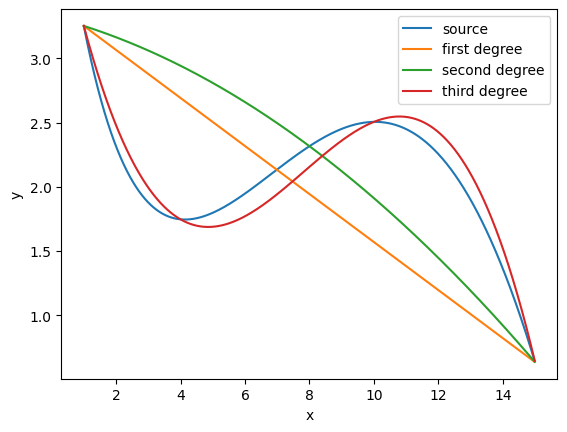

In [6]:
def f(x):
    return math.sin(x / 5.0) * math.exp(x / 10.0) + 5 * math.exp(-x / 2.0)


def value_polynomial(w_s: list[float], x: float) -> list:
    value = 0

    for i in range(len(w_s)):
        value += w_s[i] * x**i

    return value


def solve_polynomial(anchor_point: list[float]) -> list:
    a = np.array(
        [
            [anchor_point[j] ** i for i in range(len(anchor_point))]
            for j in range(len(anchor_point))
        ]
    )

    b = np.array([f(x) for x in anchor_point])

    x = solve(a, b)

    return list(x)


w_1 = solve_polynomial(anchor_point_1)
w_2 = solve_polynomial(anchor_point_2)
w_3 = solve_polynomial(anchor_point_3)

print(f"first degree poly: {w_1}")
print(f"second degree poly: {w_2}")
print(f"third degree poly: {w_3}")

x = np.arange(1, 15, 0.01)

y_source = list(map(f, x))
y_1 = list(map(lambda x: value_polynomial(w_1, x), x))
y_2 = list(map(lambda x: value_polynomial(w_2, x), x))
y_3 = list(map(lambda x: value_polynomial(w_3, x), x))

plt.plot(x, y_source, label="source")
plt.plot(x, y_1, label="first degree")
plt.plot(x, y_2, label="second degree")
plt.plot(x, y_3, label="third degree")

plt.xlabel("x")
plt.ylabel("y")

plt.legend()

# Центральная предельная теорема своими руками

## Гистограмма выборки

Будем рассмотривать экспоненциальное распределение случайно величины с $\lambda = 1$. Плотность вероятности для экспоненциального распределения будет иметь следующий вид:

$
f_X(x) = \begin{cases}
\lambda \,e^{-\lambda x} ,& x \ge 0, \\
0 ,& x < 0.
\end{cases}.
$

__Пример экспоненциального распределения в жизни:__ Пусть есть магазин, в который время от времени заходят покупатели. При определённых допущениях время между появлениями двух последовательных покупателей будет случайной величиной с экспоненциальным распределением. Среднее время ожидания нового покупателя равно $1/\lambda$. Сам параметр $\lambda$ тогда может быть интерпретирован как среднее число новых покупателей за единицу времени.

Сгенерируем из него выборку объёма 1000 и сравним гистограмму выборки и с теоретической плотностью распределения случайной величины.

In [7]:
# импортируем все необходимые библиотеки
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np

In [8]:
# сгенеруем выборку объема 1000 из распределения
rv = sts.expon()
sample = rv.rvs(1000)

# расчитаем теоритеческую плотность вероятности (pdf - probability density function) для распределения
x = np.linspace(0, 15, 1000)
pdf = rv.pdf(x)

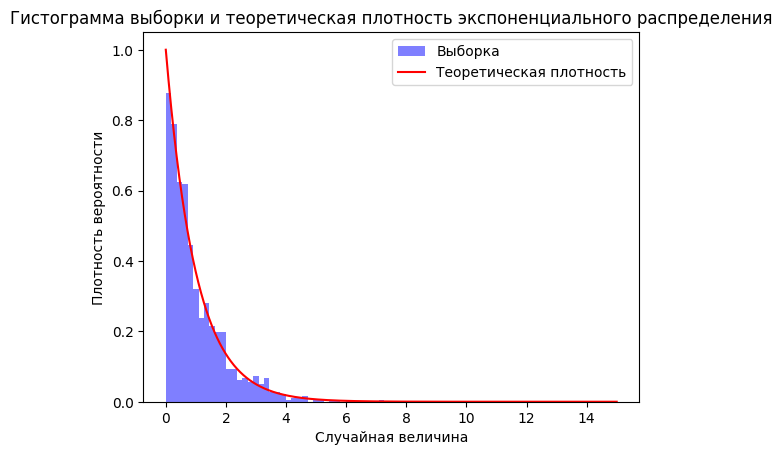

In [9]:
# построим гистограмму выборки и наложим на нее теоретическую
# оценку плотности вероятности экспоненциального распределения
def plot_pdf(x, sample, pdf, xlabel, ylabel, title):
    plt.title(title)

    plt.hist(sample, bins=40, density=True, alpha=0.5, color="blue", label="Выборка")
    plt.plot(x, pdf, color="red", label="Теоретическая плотность")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.legend()
    plt.show()


plot_pdf(
    x=x,
    sample=sample,
    pdf=pdf,
    xlabel="Случайная величина",
    ylabel="Плотность вероятности",
    title="Гистограмма выборки и теоретическая плотность экспоненциального распределения",
)

## Распределение выборочных средних

Перейдем к следующему шагу и оценим распределение выборочных средних случайной величины. Согласно Центральной Предельной Теореме выборочные средние  $\bar{X}_n = \frac{1}{n} \sum\limits_{i=1}^n X_i$ будут приближаться нормальным распределением $N(\mu = \mathbb{E}X, \sigma^2 = \frac{\mathbb{D}X}{n})$, где $n$ - объем выборки, $\mathbb{E}X$ и $\mathbb{D}X$ соответственно математическое ожидание и дисперсия рассматриваемого исходного распределения.

В нашем случае экспоненциального распределения: $\mathbb{E}X = \lambda^{-1}\, = 1$ - _математическое ожидание_, $\mathbb{D}X = \lambda^{-2}\, = 1$ - _дисперсия_.

Таким образом, __распределение выборочных средних экспоненциального распределения__ с $\lambda = 1$ будет приближаться нормальным распределением $N(\mu = 1, \sigma^2 = \frac{1}{n})$.

In [10]:
# опишем функцию, которая для объема выборки n генерирует график гистограммы
# выборочных средних случайной величины
# и теоретической оценки плотности вероятности
# для распределения выборочных средних


def generate_pdf(n):
    means = []
    rv = sts.expon()

    for _ in range(1000):
        sample = rv.rvs(n)
        sample_mean = np.mean(sample)
        means.append(sample_mean)

    mu = 1
    sigma = (1.0 / n) ** 0.5
    norm_rv = sts.norm(loc=mu, scale=sigma)
    x = np.linspace(0, 4, 100)
    pdf = norm_rv.pdf(x)

    plot_pdf(
        x=x,
        sample=means,
        pdf=pdf,
        xlabel="Выборочное среднее",
        ylabel="Плотность вероятности",
        title=f"n = {n}",
    )

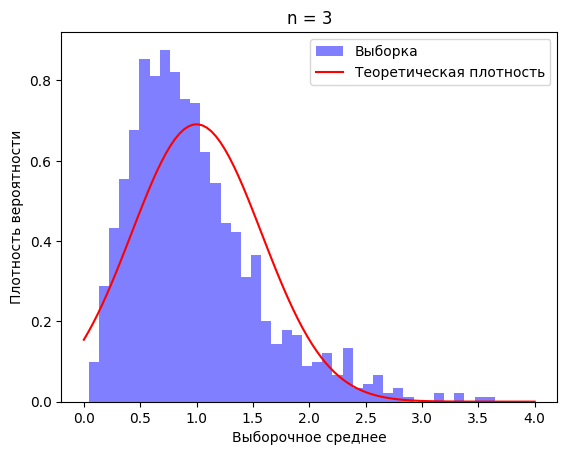

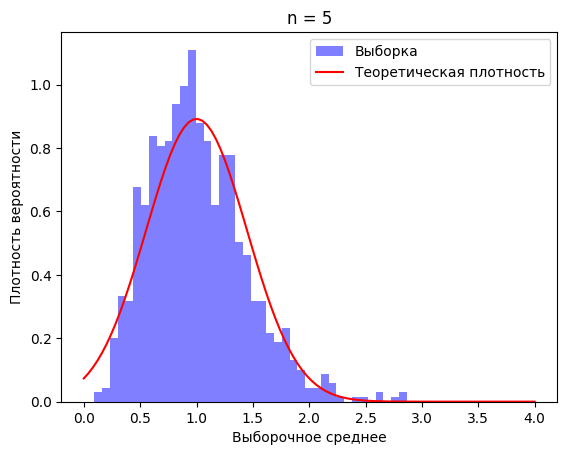

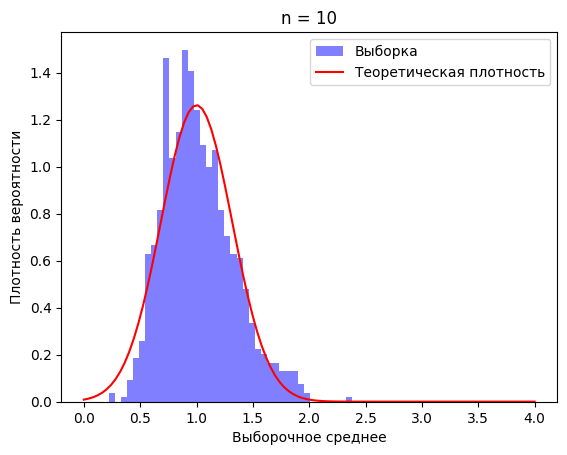

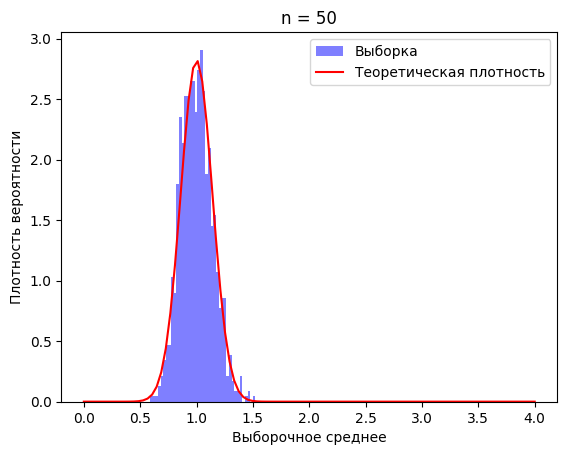

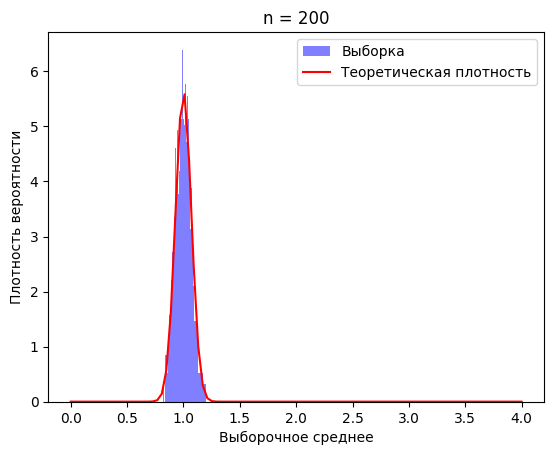

In [11]:
# построим гистограммы распределений выборочных средних и приближающих их нормальных распределений
# при различных объемах выборок n = [3, 5, 10, 50, 200]

for n in [3, 5, 10, 50, 200]:
    generate_pdf(n)

__Вывод:__ как видно из графиков, чем больше объем выборки n, тем лучше распределение выборочных средних соответствует приближающему его нормальному распределению. При n=3 распределение несимметрично и совсем не похоже на нормальное, но уже при n=50 распределение выборочных средних достаточно хорошо соответсвует нормальному. Также стоит отметить, что с ростом n уменьшается дисперсия распределения выборочных средних.